## Refit the Model
---

In [1]:
import sys, os, json
sys.path.insert(1, "../../")
from src.combine import combine_data
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
import src.monitoring.refit as refit
import src.monitoring.governance as gvrn
import src.monitoring.monitoring as mntr
import src.monitoring.utils as mu

%matplotlib inline
plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load modeling_df
dev_path = "s3://sofi-data-science/jxu/monitoring/customer-risk-v1/2021-02/modeling_df_2021-02.parquet"
modeling_df = pd.read_parquet(dev_path)
modeling_df = mu.preprocess(modeling_df)

In [3]:
# # load test_df
# test_path = "s3://sofi-data-science/jxu/monitoring/customer-risk-v1/2021-02/test_df_2021-02.parquet"
# test_df = pd.read_parquet(test_path)
# test_df = mu.preprocess(test_df)

In [4]:
# where to save artifacts
govn_path = "../../artifacts/monitoring-2021Q1/refitted"
os.makedirs(govn_path, exist_ok=True)

# load configs
with open("../../config.json", "r") as f:
    config = json.load(f)

In [5]:
test_dfs = OrderedDict()

In [6]:
mmonth = "2021-02"
s3_data_base = f"s3://sofi-data-science/jxu/monitoring/customer-risk-v1/{mmonth}"

model_name = f"customer_risk_{mmonth}.pkl"
refit_model_s3_key = f"jxu/money-risk-models/customer-risk-model/models/{model_name}"

# refitting data
train_fname = f"modeling_df_{mmonth}.parquet"
modeling_data_path = os.path.join(s3_data_base, train_fname)
modeling_base_path = "../../models"

# test data
scoring_data_base = f"s3://sofi-data-science/jxu/monitoring/customer-risk-v1/{mmonth}"
scoring_data_files = [{"fpath": f"test_df_{mmonth}.parquet", 
                       "fname": f"test_df_{mmonth}"}]


### Get and process data

In [7]:
test_df = refit.get_test_df(scoring_data_base, 
                            scoring_data_files)

test_df_2021-02 preprocessed


<AxesSubplot:>

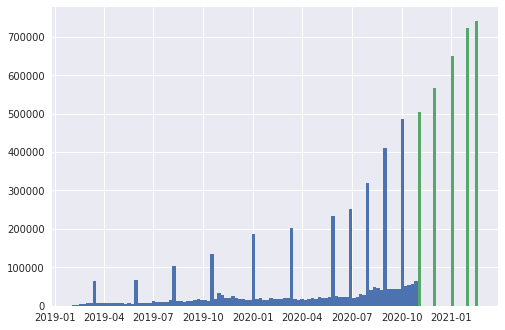

In [8]:
modeling_df.sample_date.hist(bins=100)
test_df.sample_date.hist(bins=20)

#### Refit

In [22]:
clf = refit.train(modeling_df,
                  date_col="sample_date",
                  indeterminate_col="indeterminate")

data statistics (4198767, 42)
indeterminate removed!
data statistics after removing indeterminate (2537277, 42)
modeling_df last date: 2020-10-31 00:00:00
target counts
False    2524702
True       12575
Name: target, dtype: int64
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current 

In [23]:
# save model
mu.write_pickle_to_s3(clf, "sofi-data-science", refit_model_s3_key) 

#### Governance Stuff

saving feature importance


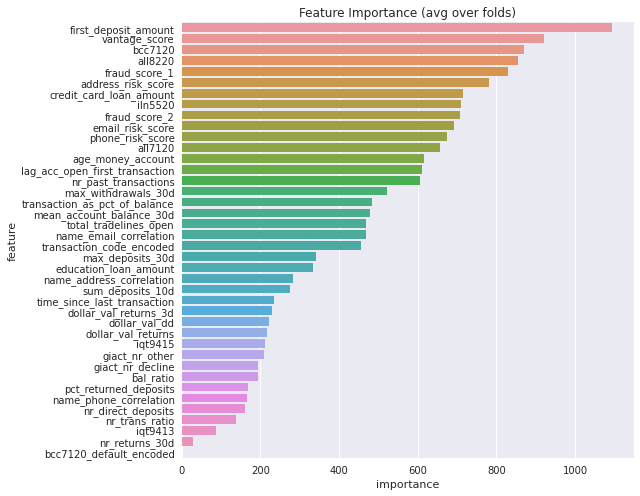

In [24]:
# save feature importance
print("saving feature importance")
gvrn.save_feature_importance_plot(clf.feature_name_, clf.feature_importances_, 
                             os.path.join(govn_path, "feature_importance.png"))


In [25]:
test_dts = test_df.sample_date.unique()

In [26]:
str(test_dts[0])

'2020-11-01T00:00:00.000000000'

#### Active Accounts

  0%|          | 0/5 [00:00<?, ?it/s]

2020-11-01 (503062, 97)
data imbalance:  108.84076157507573


 20%|██        | 1/5 [00:06<00:27,  6.80s/it]

2020-12-01 (567591, 97)
data imbalance:  104.27907404005144


 40%|████      | 2/5 [00:14<00:21,  7.12s/it]

2021-01-01 (650547, 97)
data imbalance:  179.8581697539397


 60%|██████    | 3/5 [00:22<00:15,  7.74s/it]

2021-02-01 (723696, 97)
data imbalance:  296.47521507578864


 80%|████████  | 4/5 [00:31<00:08,  8.23s/it]

2021-02-19 (740625, 97)
data imbalance:  406.71334431630976


100%|██████████| 5/5 [00:40<00:00,  8.08s/it]


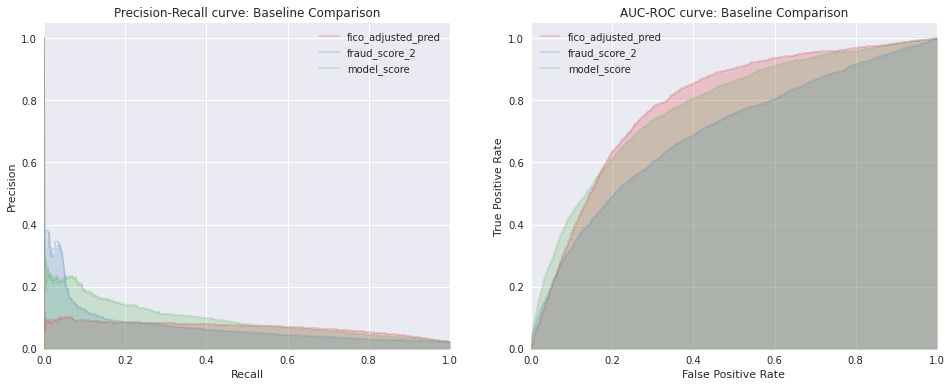

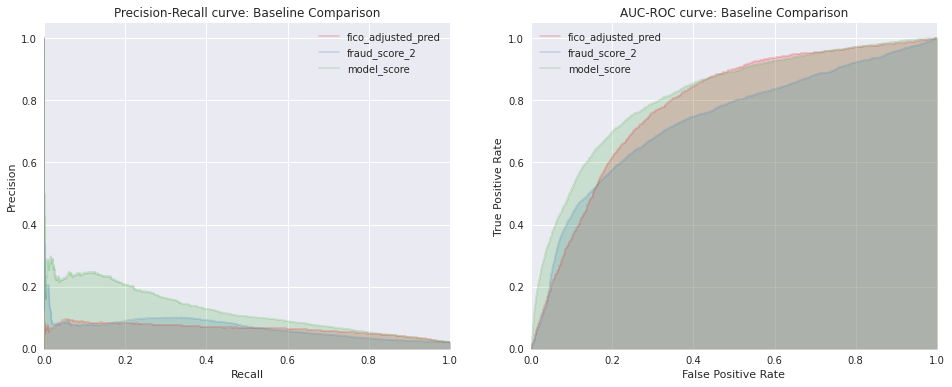

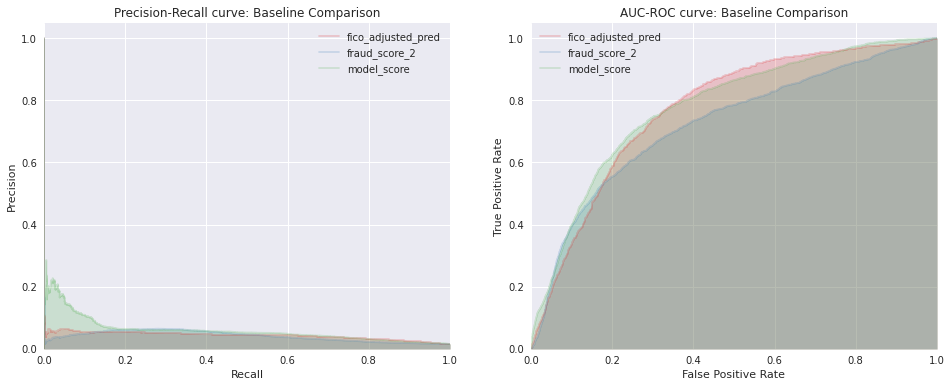

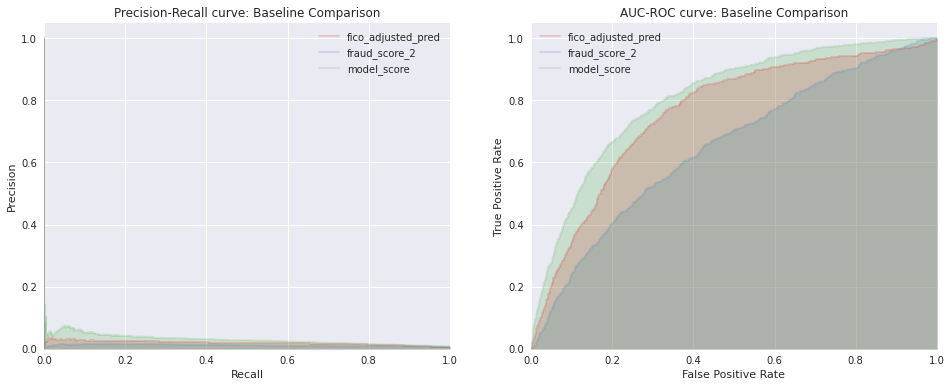

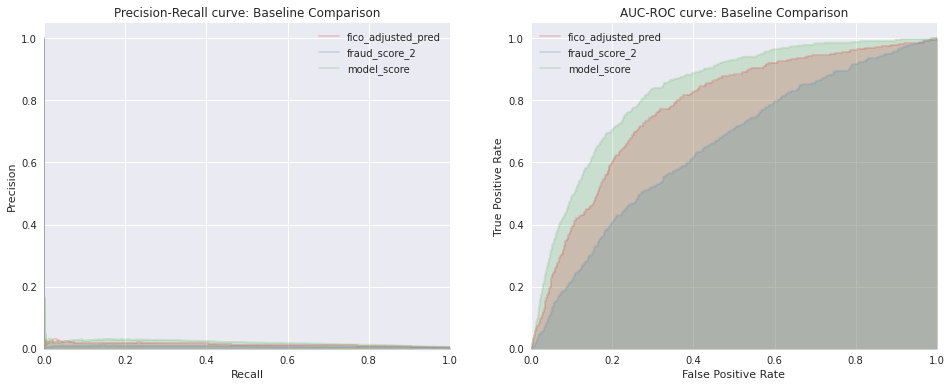

In [27]:
# get all the snapshots
for dt in tqdm(test_dts):
    dt_str = str(dt).split("T")[0]

    # set folder:
    mntr_path = os.path.join(govn_path, dt_str)
    os.makedirs(mntr_path, exist_ok=True)

    # get data on that date
    df_ = test_df[test_df.sample_date == dt]
    print(dt_str, df_.shape)

    # see data imbalance
    print("data imbalance: ", 1/df_.target.value_counts(normalize=True).iloc[1])

    # should have been processed when loaded, if not uncomment
    df_ = mu.prep_customer_data(df_)

    # make model pred and score
    df_["model_pred"] = clf.predict_proba(df_[clf.feature_name_])[:,1]
    df_["model_score"] = mu.scale_scores(df_["model_pred"])

    # insert into records
    test_dfs[dt_str] = df_
    pred_cols = ["fico_adjusted_pred", "fraud_score_2", "model_score"]
    report = mntr.get_pred_reports(df_[df_.is_active], "target", pred_cols, dropna=True)

    # store report in monitoring
    report.to_csv(os.path.join(mntr_path, f"{dt_str}_perf.csv"))

    # model prediction
    mntr.get_segmented_performances(
        {dt_str: df_[df_.is_active]},
        "target",
        ["model_score"],
        mntr_path,
        model_name="customer_risk",
    )

    # auc/pr plots
    plot_df = df_[df_.is_active].copy()
    plot_df = plot_df[
        ~plot_df[pred_cols].isna().any(axis=1) 
        & plot_df["fico_score"].between(300, 850)
    ]
    mntr.save_valid_performance_plots(
        {dt_str: plot_df}, "target", pred_cols, mntr_path, dropna=False
    )

Because we were looking at a segment behavior, the refitted model actually performed worse due to the population shift. Let's take a look at the full performance. Also, we need to find ways to plot model performances when having some benchmark measures (fico) missing.

#### Full Population

  0%|          | 0/5 [00:00<?, ?it/s]

2020-11-01 (503062, 97)
data imbalance:  108.84076157507573


 20%|██        | 1/5 [00:23<01:33, 23.31s/it]

2020-12-01 (567591, 97)
data imbalance:  104.27907404005144


 40%|████      | 2/5 [00:49<01:15, 25.20s/it]

2021-01-01 (650547, 97)
data imbalance:  179.8581697539397


 60%|██████    | 3/5 [01:20<00:55, 27.78s/it]

2021-02-01 (723696, 97)
data imbalance:  296.47521507578864


 80%|████████  | 4/5 [01:54<00:30, 30.33s/it]

2021-02-19 (740625, 97)
data imbalance:  406.71334431630976


100%|██████████| 5/5 [02:29<00:00, 29.97s/it]


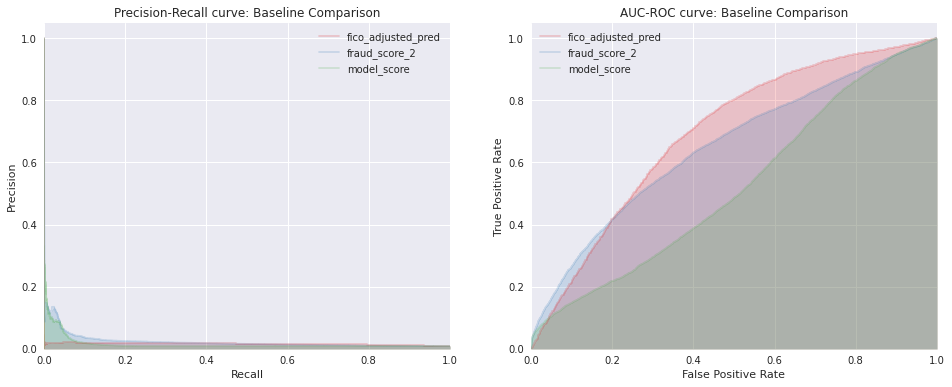

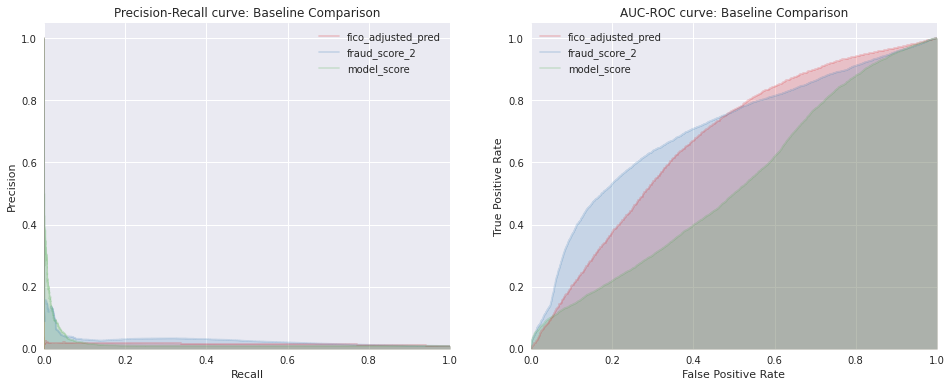

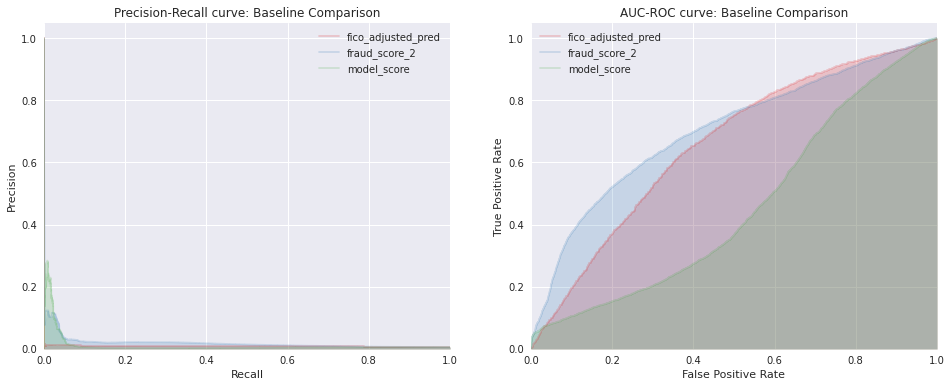

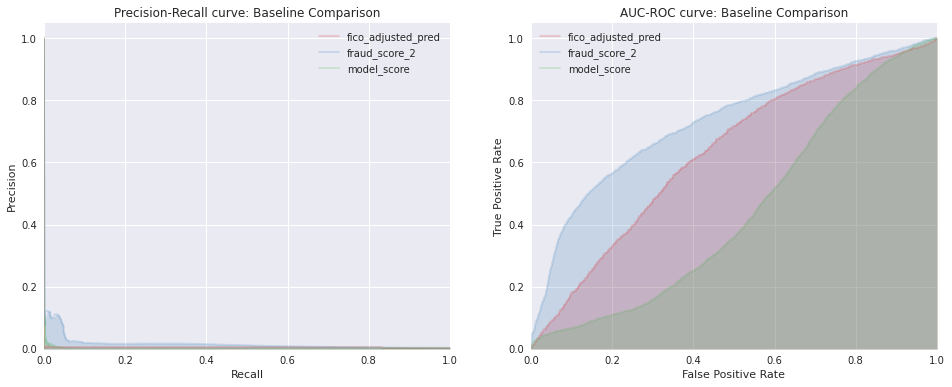

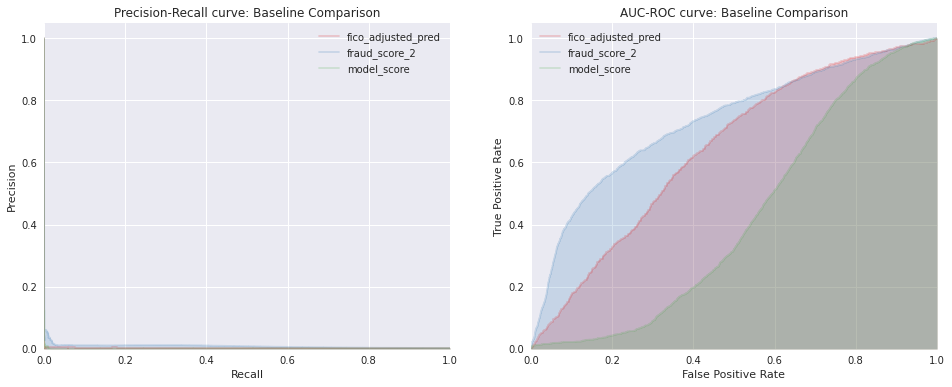

In [15]:
# get full population
for dt in tqdm(test_dts):
    dt_str = str(dt).split("T")[0]

    # set folder:
    mntr_path = os.path.join(govn_path, dt_str+"_all")
    os.makedirs(mntr_path, exist_ok=True)

    # get data on that date
    df_ = test_df[test_df.sample_date == dt]
    print(dt_str, df_.shape)

    # see data imbalance
    print("data imbalance: ", 1/df_.target.value_counts(normalize=True).iloc[1])

    # should have been processed when loaded, if not uncomment
    df_ = mu.prep_customer_data(df_)

    # make model pred and score
    df_["model_pred"] = clf.predict_proba(df_[clf.feature_name_])[:,1]
    df_["model_score"] = mu.scale_scores(df_["model_pred"])

    # insert into records
    test_dfs[dt_str] = df_
    pred_cols = ["fico_adjusted_pred", "fraud_score_2", "model_score"]
    report = mntr.get_pred_reports(df_, "target", pred_cols, dropna=True)

    # store report in monitoring
    report.to_csv(os.path.join(mntr_path, f"{dt_str}_perf.csv"))

    # model prediction
    mntr.get_segmented_performances(
        {dt_str: df_},
        "target",
        ["model_score"],
        mntr_path,
        model_name="customer_risk",
    )

    # auc/pr plots
    plot_df = df_.copy()
    plot_df = plot_df[
        ~plot_df[pred_cols].isna().any(axis=1) 
        & plot_df["fico_score"].between(300, 850)
    ]
    mntr.save_valid_performance_plots(
        {dt_str: plot_df}, "target", pred_cols, mntr_path, dropna=False
    )

saving SHAP


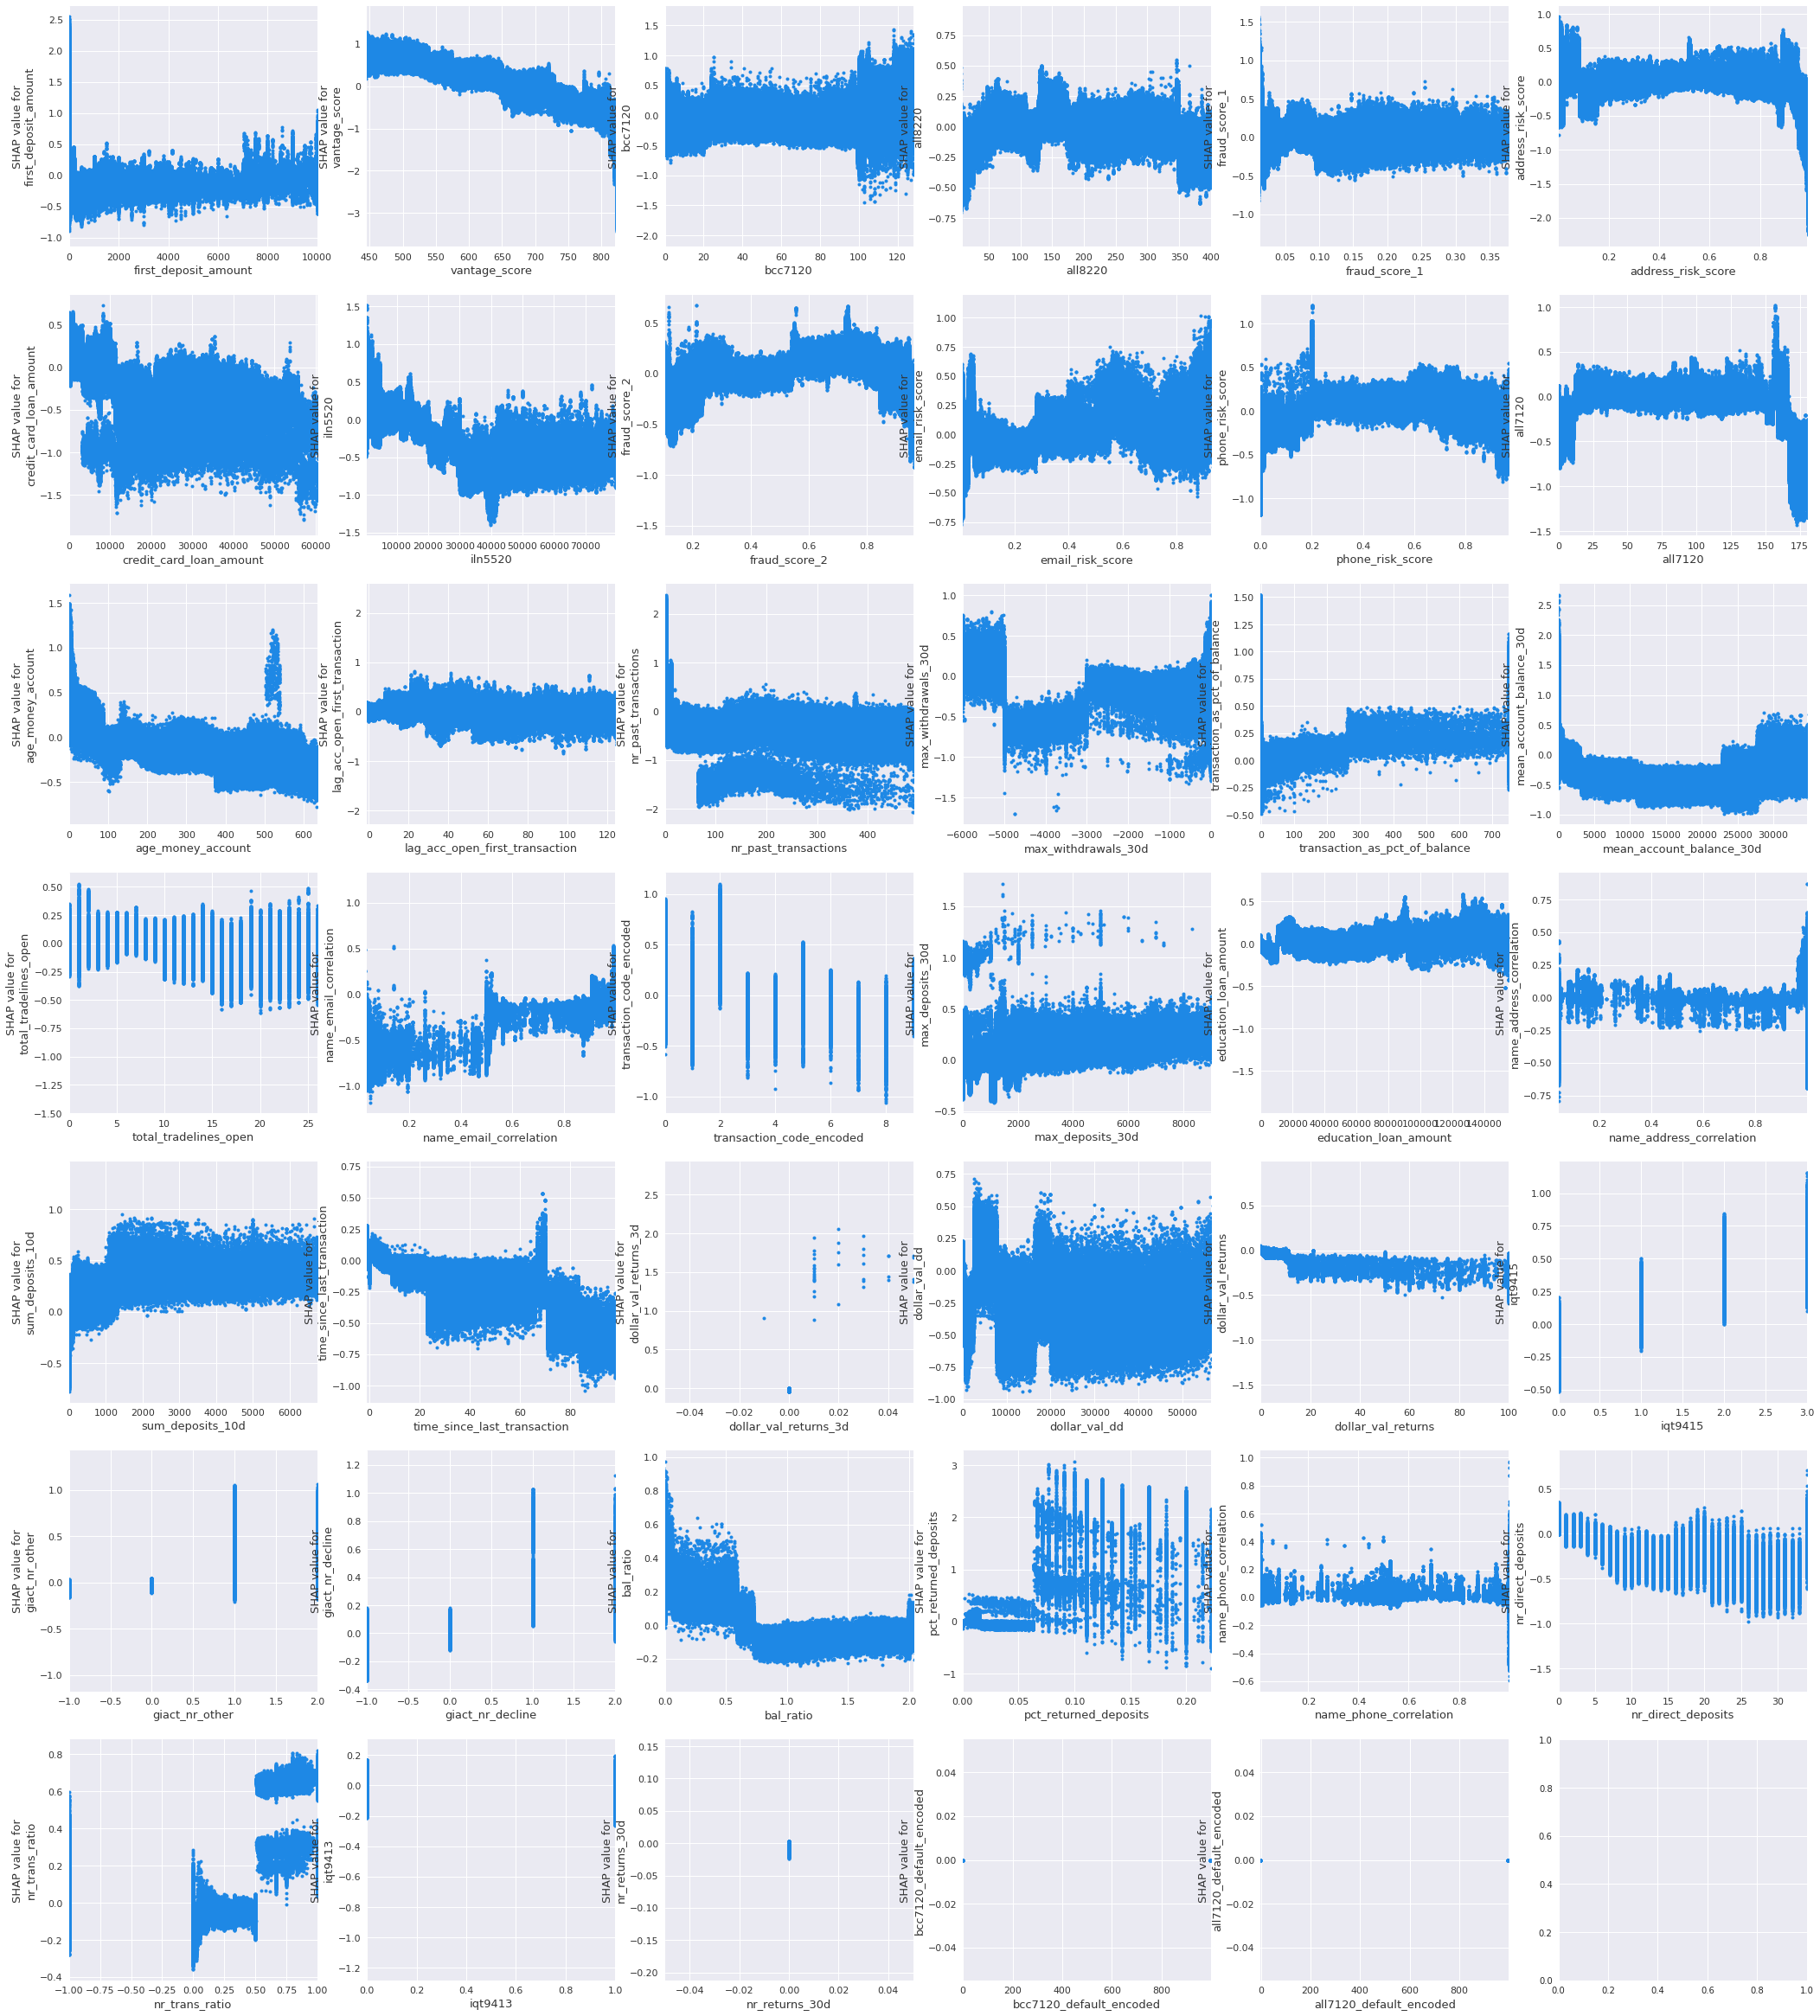

In [16]:
# feature importance order
# features_by_imp = gvrn.get_feature_by_importance(clf)

# print("saving SHAP")
# gvrn.save_shap_dependence(clf, modeling_df, features_by_imp,
#                           os.path.join(govn_path, "shap"))

<AxesSubplot:>

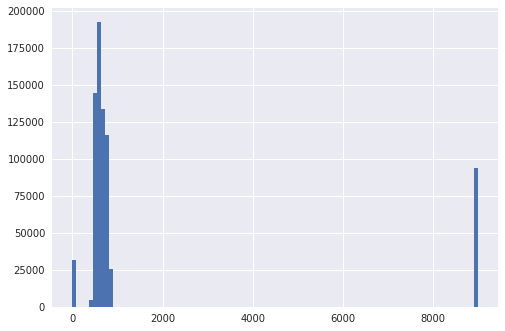

In [24]:
# 2/19/2021
df_tmp = test_df[test_df.sample_date == test_df.sample_date.max()]
df_tmp.loc[df_tmp.fico_score.isna(), "fico_score"] = -1
df_tmp.fico_score.hist(bins=100)

<AxesSubplot:>

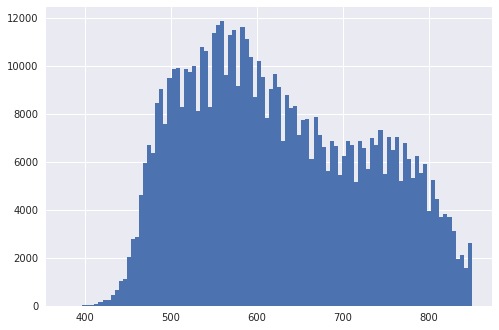

In [25]:
df_tmp[df_tmp.fico_score.between(300, 850)].fico_score.hist(bins=100)

In [26]:
df_tmp.is_active.value_counts()

False    559018
True     181607
Name: is_active, dtype: int64

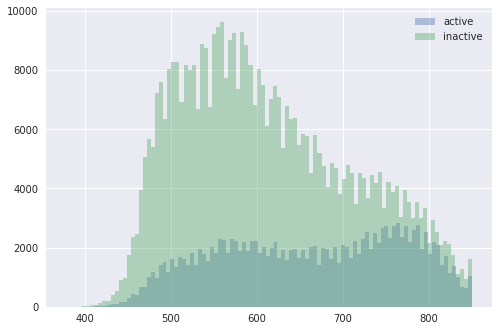

In [32]:
df_tmp[(df_tmp.fico_score.between(300, 850)) & 
       df_tmp.is_active]["fico_score"].hist(bins=100, alpha=0.4, label="active")
df_tmp[(df_tmp.fico_score.between(300, 850)) & 
       ~(df_tmp.is_active)]["fico_score"].hist(bins=100, alpha=0.4, label="inactive")
plt.legend()

<AxesSubplot:>

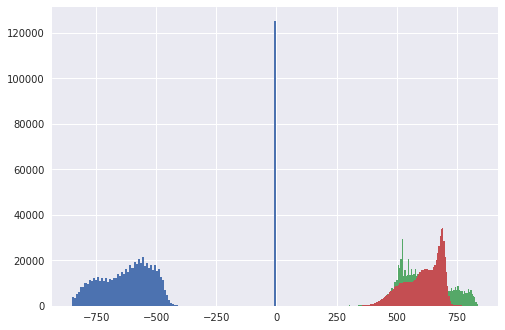

In [50]:
plot_df.fico_adjusted_pred.hist(bins=100)
plot_df.vantage_score.hist(bins=100)
plot_df.model_score.hist(bins=100)

In [47]:
plot_df.vantage_score.isna().value_counts()

False    693587
True      47038
Name: vantage_score, dtype: int64

In [48]:
plot_df.fico_adjusted_pred.isna().value_counts()

False    740625
Name: fico_adjusted_pred, dtype: int64

In [49]:
plot_df.fraud_score_2.isna().value_counts()

False    740625
Name: fraud_score_2, dtype: int64